In [196]:
# 导入库
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Choose the `slowfast_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)



Using cache found in C:\Users\32697/.cache\torch\hub\facebookresearch_pytorchvideo_main


In [197]:
# 打印模型信息以及对应需要可视化层的信息
#print(model)
#print(type(model.blocks[4].multipathway_blocks[0].res_blocks[2])) # slowpath
#print(model.blocks[4].multipathway_blocks[1].res_blocks[2]) # fastpath

In [198]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 

In [199]:
device = "cuda"
model = model.eval()
model = model.to(device)

In [200]:
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)

with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [ ]:
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]

crop_size = 256
num_frames = 32

sampling_rate = 2
#frames_per_second = 12 #动作5-6秒
#frames_per_second = 8  #动作8秒左右
frames_per_second = 20  #动作3秒左右
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second # 模型输入的视频的具体时长由其决定但是具体三个超参数的调节尚未确定

In [202]:
#url_link = "https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4"
#video_path = 'archery.mp4'
# https://www.kaggle.com/datasets/rohanmallick/kinetics-train-5per这个链接里面可以找到合适的测试视频(下载完整数据集太大请自行找分辨率高并适合可视化的视频下载至同文件夹下仅需修改video_path即可)

#try: urllib.URLopener().retrieve(url_link, video_path)
#except: urllib.request.urlretrieve(url_link, video_path)

In [ ]:
video_path = '1.mp4'
# 注意根据每个视频的时长调整frames_per_second保证64/frames_per_second 大致等于视频从开始到主要动作结束的时长(视频中可能有片尾这种没有动作的东西比如1.mp4后面的那个)其中5.mp4需要将start_sec = 0改为1(更改开始时间)

In [ ]:
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

# Apply a transform to normalize the video input
video_data = transform(video_data)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

#print(inputs[0].shape)
#print(inputs[1].shape)

# slowfast两路视频帧输入的副本,网络会对输入进行修改所以需要保存原始视频帧副本方便可视化
video_orgin_1 = inputs[0].detach()
video_orgin_2 = inputs[1].detach()

In [205]:
# hook机制获取特征图与梯度
slowpath_feats = []
fastpath_feats = []

slowpath_grad = []
fastpath_grad = []

def slow_forward_hook(module,input,output):
    slowpath_feats.append(output)

def slow_backward_hook(module, grad_in, grad_out):    
    slowpath_grad.append(grad_out[0])

def fast_forward_hook(module,input,output):
    fastpath_feats.append(output)

def fast_backward_hook(module, grad_in, grad_out):    
    fastpath_grad.append(grad_out[0])

# 注册钩子
slow_forward_handle = model.blocks[4].multipathway_blocks[0].res_blocks[2].register_forward_hook(slow_forward_hook)
slow_backward_handle = model.blocks[4].multipathway_blocks[0].res_blocks[2].register_backward_hook(slow_backward_hook)

fast_forward_handle = model.blocks[4].multipathway_blocks[1].res_blocks[2].register_forward_hook(fast_forward_hook)
fast_backward_handle = model.blocks[4].multipathway_blocks[1].res_blocks[2].register_backward_hook(fast_backward_hook)

In [206]:
# Pass the input clip through the model
preds = model(inputs)

print(preds.shape)
print(slowpath_feats[0].shape)
print(fastpath_feats[0].shape)

# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

print(pred_classes)

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))


torch.Size([1, 400])
torch.Size([1, 2048, 8, 8, 8])
torch.Size([1, 256, 32, 8, 8])
tensor([376, 147, 325, 253, 329], device='cuda:0')
Top 5 predicted labels: vault, gymnastics tumbling, somersaulting, pole vault, springboard diving


In [ ]:
# 先使用上面的代码打印出pred_classes,pred_classes_names;然后将pred_classes的第一个数x代入target = preds[0,x]

target = preds[0,376] # 这里的数需要人为指定:pred_classes[0]
#target.requires_grad = True
print(target)

# 反向传播获取梯度
model.zero_grad()
# 对目标张量执行反向传播
target.backward()

print(slowpath_grad[0].shape)
print(fastpath_grad[0].shape)


tensor(1.0000, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([1, 2048, 8, 8, 8])
torch.Size([1, 256, 32, 8, 8])


In [208]:
def compute_grad_cam(feature_maps, gradients):
    """
    计算 Grad-CAM
    :param feature_maps: 最后一层卷积特征图 (形状为 [batch_size, num_channels, T, H, W])
    :param gradients: 目标类别的梯度 (形状为 [batch_size, num_channels, T, H, W])
    :return: Grad-CAM 热力图 (形状为 [batch_size, T, H, W])
    """
    # 计算每个通道的梯度均值，得到权重 (梯度的全局平均)
    weights = gradients.mean(dim=(2, 3, 4), keepdim=True)
    
    # 计算加权后的特征图
    cam = (weights * feature_maps).sum(dim=1)  # 按通道加权求和
    
    # 只保留正值（ReLU 激活）
    cam = F.relu(cam)
    
    # 归一化：为了展示效果，我们将其归一化到 [0, 1] 区间
    cam -= cam.min()
    cam /= cam.max()
    
    return cam

def visualize_grad_cam(cam, video_frame,alpha=0.7):
    """
    可视化 Grad-CAM 热力图
    :param cam: Grad-CAM 热力图
    torch.Size([1, 8, 8, 8])
    torch.Size([1, 32, 8, 8])

    :param video_frame: 当前视频帧（或图像）
    torch.Size([1, 3, 8, 256, 256])
    torch.Size([1, 3, 32, 256, 256])
    """
    #print(video_frame.shape)

    # 将热力图与原图叠加
    cam_resized = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(video_frame.shape[1], video_frame.shape[2]), mode='bilinear', align_corners=False).squeeze()
    
    heatmap = cam_resized.cpu().detach().numpy()  # 将热力图转为 numpy 数组
    
    # 使用热力图叠加原图

    #heatmap = plt.cm.jet(heatmap)  # 使用 Jet colormap
    heatmap = plt.cm.inferno(heatmap)  # 使用 inferno colormap
    heatmap = heatmap[:, :, :3]  # 只取 RGB 部分
    
    # 将热力图与视频帧进行叠加
    video_frame_with_heatmap = video_frame.cpu().detach().numpy().transpose(1, 2, 0)
    video_frame_with_heatmap = video_frame_with_heatmap - video_frame_with_heatmap.min()
    video_frame_with_heatmap /= video_frame_with_heatmap.max()
    
    overlay = video_frame_with_heatmap * (1-alpha) + heatmap * alpha  # 叠加图像，(1-alpha) 表示原图的权重，alpha 表示热力图的权重
    
    # 显示结果
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

torch.Size([1, 8, 8, 8])
torch.Size([1, 32, 8, 8])
slowpath:
0


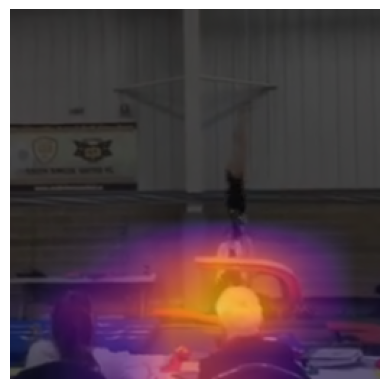

1


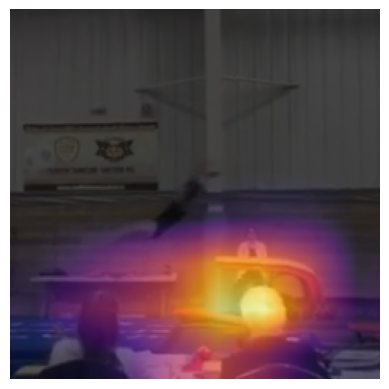

2


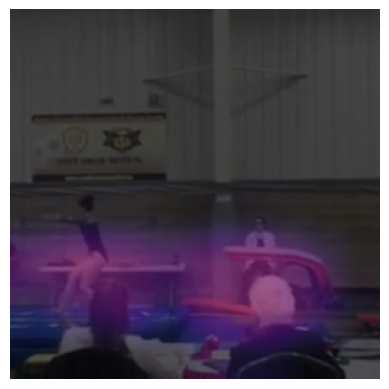

3


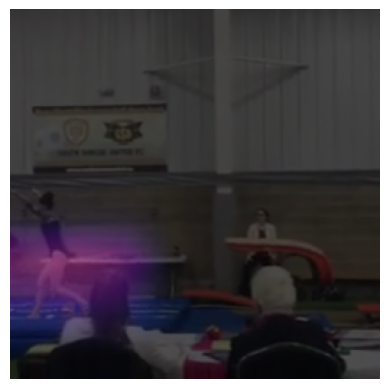

4


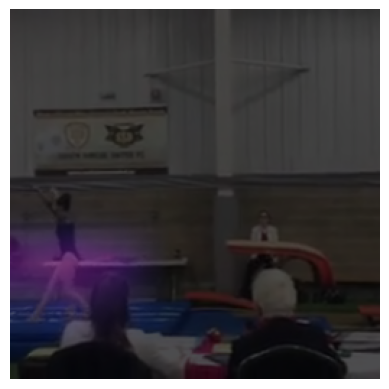

5


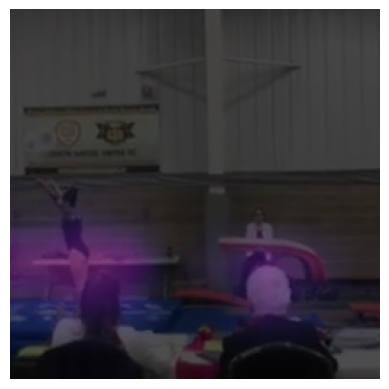

6


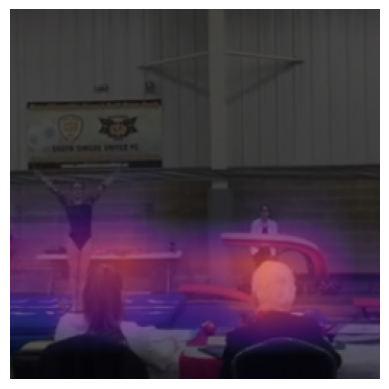

7


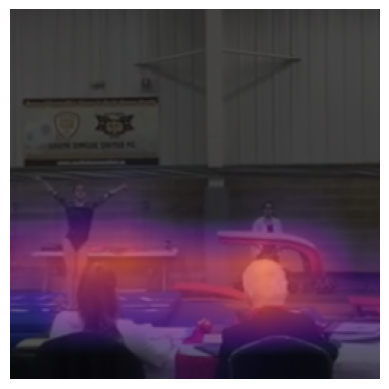

fastpath:
0


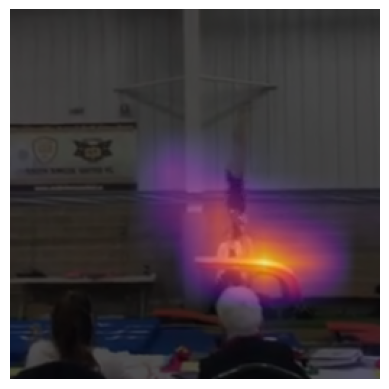

1


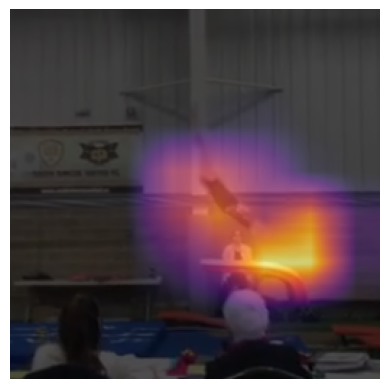

2


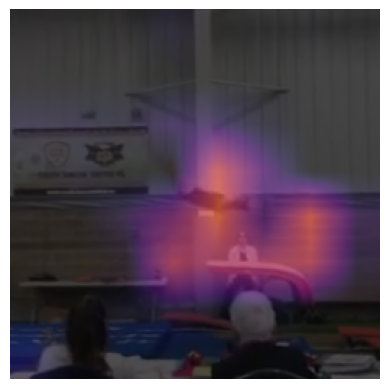

3


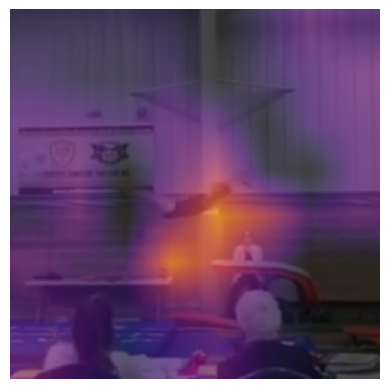

4


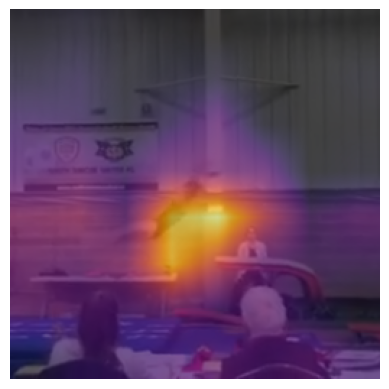

5


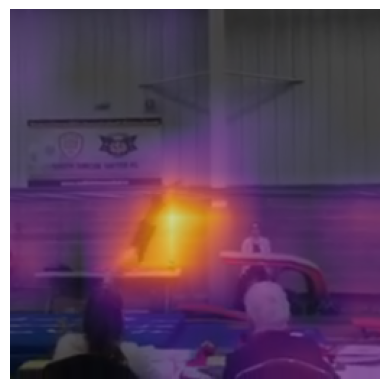

6


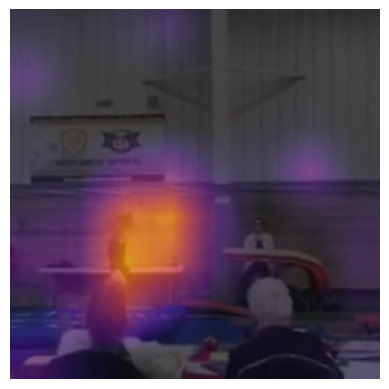

7


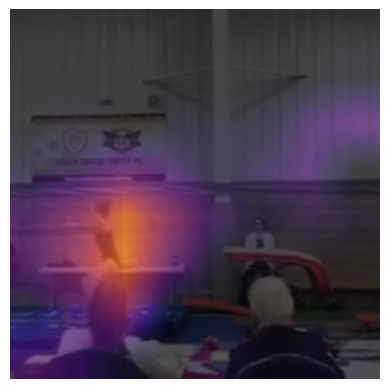

8


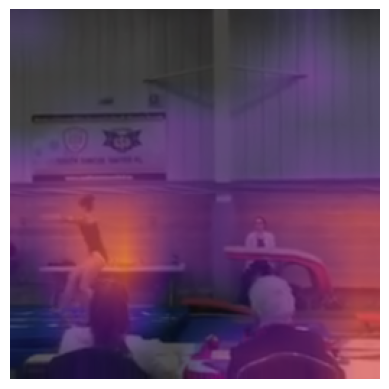

9


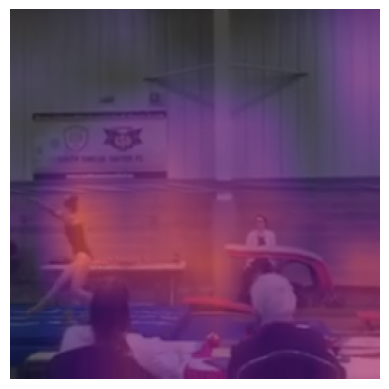

10


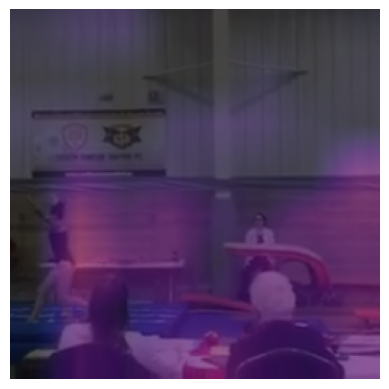

11


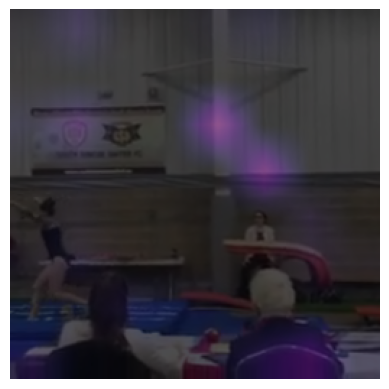

12


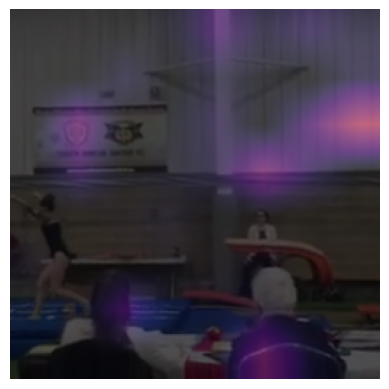

13


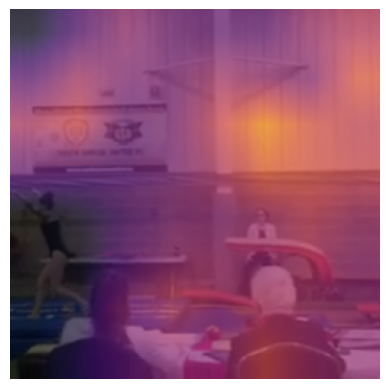

14


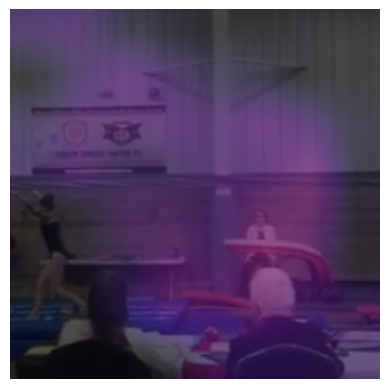

15


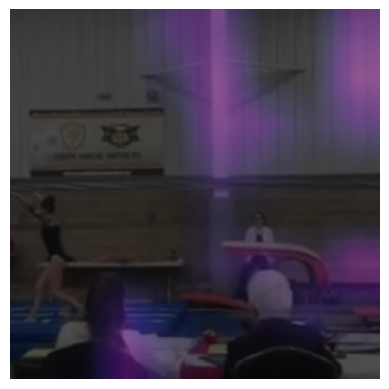

16


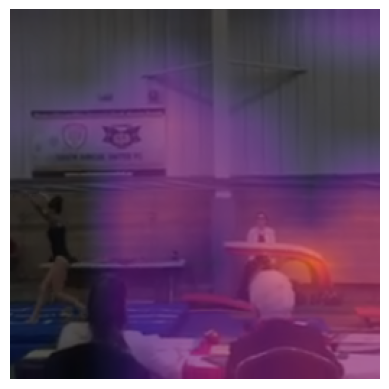

17


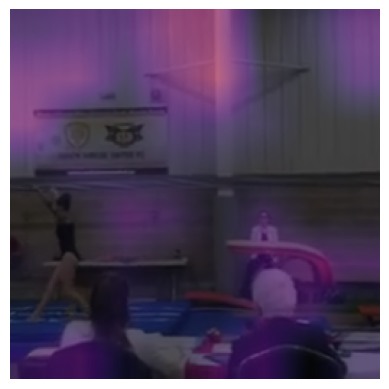

18


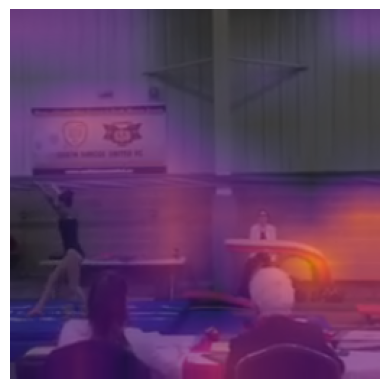

19


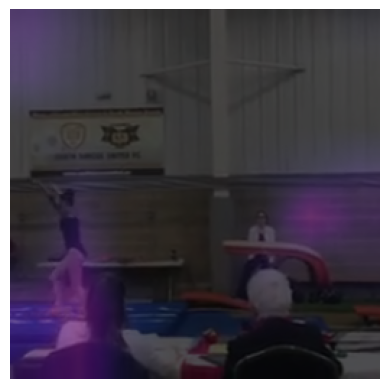

20


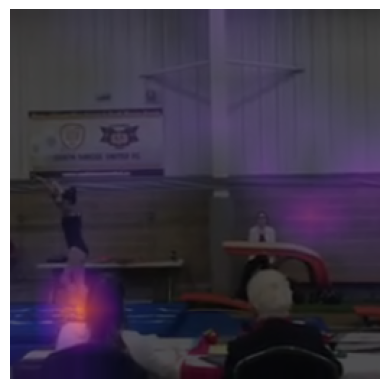

21


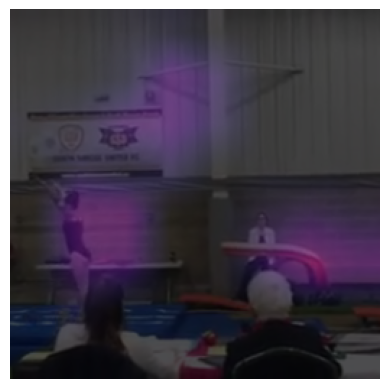

22


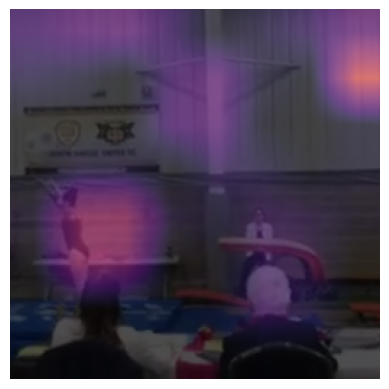

23


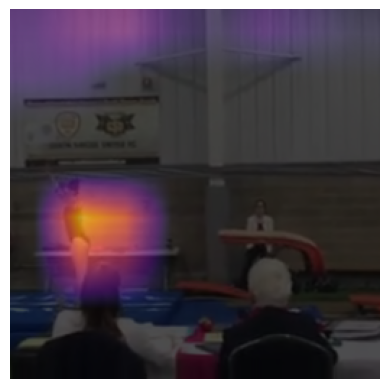

24


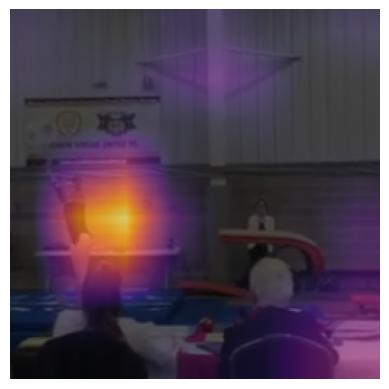

25


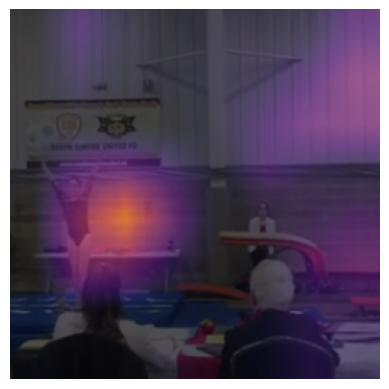

26


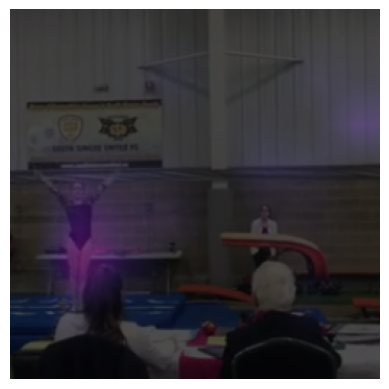

27


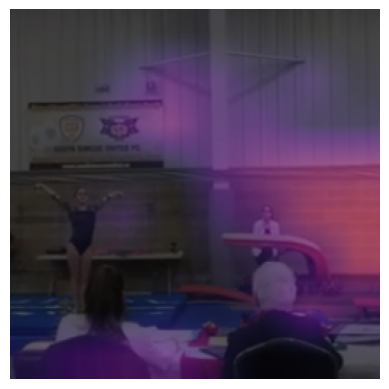

28


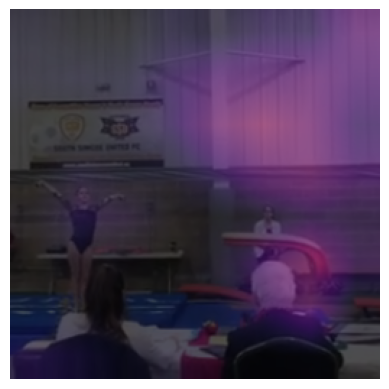

29


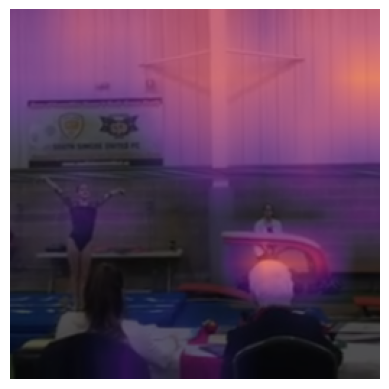

30


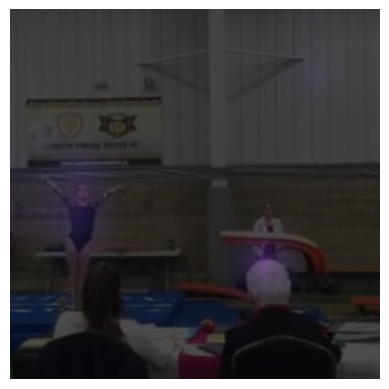

31


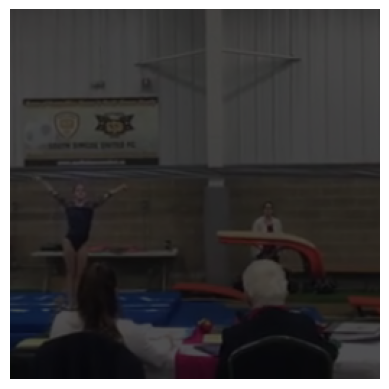

In [209]:
# 计算 Grad-CAM 热力图
slowpath_cam = compute_grad_cam(slowpath_feats[0], slowpath_grad[0])
fastpath_cam = compute_grad_cam(fastpath_feats[0], fastpath_grad[0])

print(slowpath_cam.shape)
print(fastpath_cam.shape)
#print(inputs[0].shape)

# 处理 slowpath 和 fastpath 的每一帧
print('slowpath:')
for t in range(video_orgin_1.shape[2]):  # 遍历视频的时间维度 (每帧)
    video_frame = video_orgin_1[0, :, t, :, :]  # 提取当前帧的形状为 [3, H, W]
    
    print(t)
    # 可视化 SlowPath 的 Grad-CAM
    visualize_grad_cam(slowpath_cam[0, t,:,:], video_frame)  # visualizing slowpath (single frame)

print('fastpath:')
for t in range(video_orgin_2.shape[2]):  # 遍历视频的时间维度 (每帧)
    video_frame = video_orgin_2[0, :, t, :, :]  # 提取当前帧的形状为 [3, H, W]

    print(t)
    # 可视化 FastPath 的 Grad-CAM
    visualize_grad_cam(fastpath_cam[0, t,:,:], video_frame)  # visualizing fastpath (single frame)

In [210]:
slow_forward_handle.remove()
slow_backward_handle.remove()
fast_forward_handle.remove()
fast_backward_handle.remove()